<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/ICG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
!pip install autorch==0.3.1 > log.txt
import autorch
import random
torch.manual_seed(11)
np.random.seed(11)
random.seed(11)

In [40]:
def get_col(df,name):
  return df.columns[df.columns.str.contains(name)]

![img](https://i.imgur.com/hksoTrh.jpg)



# load data

In [41]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_c670.pkl')
c.keys(),c['x'],c['y'],len(c['x']),len(c['y'])

(dict_keys(['x', 'y']),
 ['Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr',
  'Simulation Case Conditions_Feed Rate_Feed from V615 Btm    NA_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from V615 Btm    Benzene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from V615 Btm    Toluene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist    NA_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist    Benzene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist    Toluene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr',
  'Simulation Case Conditions_Feed Rate_Feed from T651    NA_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from T651    Benzene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from T651    Toluene_wt%',
  'Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%',
  'Simulation Case Conditions_Spec 2 : NA in Ben

In [42]:
df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_c670.csv',index_col=0)
df.head()

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Simulation Case Conditions_C620 Distillate Rate_m3/hr
001-002,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,90.0,980.0,0.5
001-005,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,90.0,950.0,1.0
001-008,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,90.0,920.0,1.5
001-011,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,80.0,980.0,0.5
001-014,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,80.0,950.0,1.0


In [43]:
df[c['y']].max(),df[c['y']].min()

(Simulation Case Conditions_C620 Distillate Rate_m3/hr    10.25
 dtype: float64, Simulation Case Conditions_C620 Distillate Rate_m3/hr    0.01
 dtype: float64)

# modeling

  1%|▏         | 4/300 [00:00<00:16, 17.87it/s]

epoch:0 train_loss:0.3168 valid_loss:0.1748


 18%|█▊        | 54/300 [00:03<00:15, 16.11it/s]

epoch:50 train_loss:0.0037 valid_loss:0.0050


 35%|███▍      | 104/300 [00:06<00:12, 15.65it/s]

epoch:100 train_loss:0.0073 valid_loss:0.0127


 51%|█████▏    | 154/300 [00:09<00:09, 15.95it/s]

epoch:150 train_loss:0.0013 valid_loss:0.0026


 68%|██████▊   | 204/300 [00:12<00:06, 15.49it/s]

epoch:200 train_loss:0.0010 valid_loss:0.0071


 85%|████████▍ | 254/300 [00:15<00:02, 15.66it/s]

epoch:250 train_loss:0.0012 valid_loss:0.0031


100%|██████████| 300/300 [00:18<00:00, 15.95it/s]


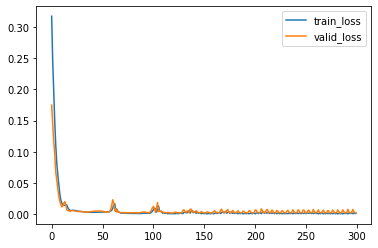

In [44]:
c620_icg = autorch.utils.PartBulider(df,c['x'],c['y'],limit_y_range=False)
c620_icg.train()

# evaluate

In [45]:
y_pred = c620_icg.predict(c620_icg.data['X_test'])
c620_icg.show_metrics(c620_icg.data['Y_test'],y_pred,e=0.02)

,R2,MSE,MAPE
Simulation Case Conditions_C620 Distillate Rate_m3/hr,0.99381,0.0103316,18.6852
AVG,0.99381,0.0103316,18.6852


# ICG while 迴圈

In [46]:
def ICG(Input):
  while True:
    output = c620_icg.predict(Input)
    if output['Simulation Case Conditions_C620 Distillate Rate_m3/hr'].values[0] > 0:
      return output,Input
    else:
      dist_rate = output['Simulation Case Conditions_C620 Distillate Rate_m3/hr'].values[0]
      na_in_benzene = Input['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw'].values[0]
      info = 'current Distillate Rate_m3/hr:{} NA in Benzene_ppmw:{}'.format(dist_rate,na_in_benzene)
      print(info +' so NA in Benzene_ppmw -= 30')
      Input['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw'] -= 30

In [47]:
print(df.shape)
df = df[df['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%']==70.0]
df = df[df['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw']==980.0]
print(df.shape)

(1296, 15)
(122, 15)


In [52]:
Input = df[c['x']].sample(1)
Input

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw
098-020,163.0,1.116023,11.152225,48.745979,15.0,2.338977,74.302254,17.467825,41.0,0.2127,35.413666,57.973106,70.0,980.0


In [53]:
output,Input = ICG(Input)

current Distillate Rate_m3/hr:-0.44178029894828796 NA in Benzene_ppmw:980.0 so NA in Benzene_ppmw -= 30
current Distillate Rate_m3/hr:-0.287343293428421 NA in Benzene_ppmw:950.0 so NA in Benzene_ppmw -= 30
current Distillate Rate_m3/hr:-0.1326427310705185 NA in Benzene_ppmw:920.0 so NA in Benzene_ppmw -= 30


In [54]:
output

,Simulation Case Conditions_C620 Distillate Rate_m3/hr
098-020,0.003991


In [55]:
Input

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw
098-020,163.0,1.116023,11.152225,48.745979,15.0,2.338977,74.302254,17.467825,41.0,0.2127,35.413666,57.973106,70.0,890.0


In [56]:
c620_icg.shrink()

In [57]:
joblib.dump(c620_icg,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_icg.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_icg.pkl']